<a href="https://colab.research.google.com/github/YuliLanir/WeizmannProject/blob/main/WQED_diff_transmon_gamma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# imports
import matplotlib.pyplot as plt
from os import path
import numpy as np
import scipy
import scipy.signal
from qutip import *
from helper_functions_new import *

ModuleNotFoundError: ignored

In [ ]:
##########################################################################
# we want to see the effect of diff error rates of gamma between tansmons
## Sasha : the change of omega needs to be smaller than the change of gamma (<10%)
##########################################################################

# parameters
N = 6 # number of transmons in the model
c_light = 3E-1 #  0.3 m/ns
d = 5E-3 # 0.005 m

err = 0.05 ## we assume max 5% error of transmon frequency difference due to fabrication and physical error
omega0 = 6 * (2*np.pi) # omega0 ~ 6 GHz
gamma0 = 0.03 * (2*np.pi) # gamma_1D ~ 30 MHz
phi0 = np.round(omega0*d/c_light / (2*np.pi),5) # phi = 0.1


alpha = -0.25 * (2*np.pi) # 200 MHz
q_dim = 2 # Use only first two transmon levels
r_cavity = -0.99 # cavity/mirror reflection coefficient



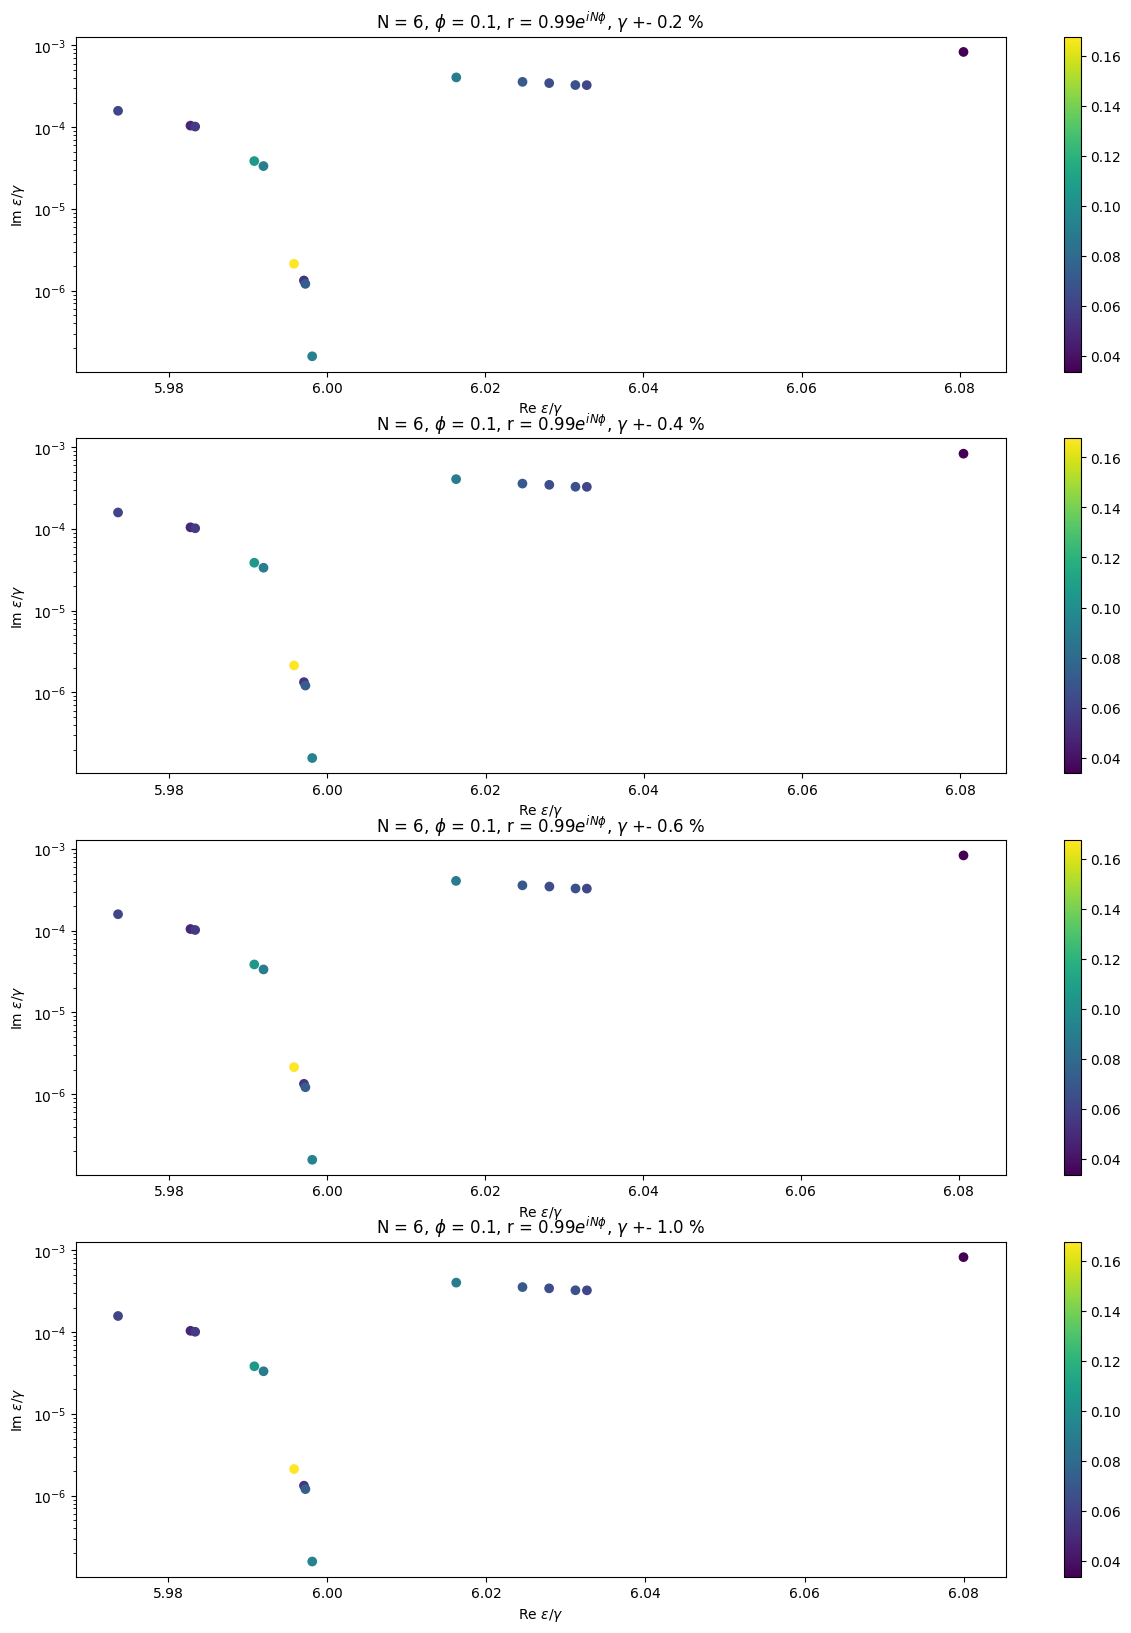

In [ ]:
##########################################################################################
# Plot two-eigen state spectrum with the cavity (mirror) for different gamma err values
##########################################################################################

err_values = [0.002, 0.004, 0.006,0.01]  # List of err values to iterate over

fig, axs = plt.subplots( len(err_values),1,figsize=(15,20))  # Create subplots for each err value

for i, err in enumerate(err_values):
    omega_val, gamma_val = err_val_gamma(err, omega0, gamma0, N, d,)
    H0r = construct_full_H(N, omega_val, d, gamma_val, phi0, r_cavity)
    e_val_2exc_r, e_vec_2exc_r = get_2excitations_states(N, H0r)

    iprs_r = []
    for v in range(len(e_vec_2exc_r)):
        A, ipr = get_amplitudes(e_vec_2exc_r[v], N)
        iprs_r.append(ipr)

    ax = axs[i]
    spec_r = ax.scatter(np.real(e_val_2exc_r), -np.imag(e_val_2exc_r), c=iprs_r, label=r"$~$")

    ax.set_xlabel(r'Re $\epsilon$/$\gamma$')
    ax.set_ylabel(r'Im $\epsilon$/$\gamma$')
    ax.set_yscale('log')

    cbar_r = fig.colorbar(spec_r, ax=ax)
    ax.set_title(f'N = 6, $\phi$ = 0.1, r = 0.99$e^{{iN\phi}}$, $\gamma$ +- {err*100} %')

[0.18944834591566218, 0.19013478102917958, 0.1883389453829247, 0.18733889011826363, 0.1867762439106958, 0.19035924002904406]
[0.18012401222348956, 0.18300342061663305, 0.19531806571193755, 0.18950441505369273, 0.19275007200724203, 0.19420750509255902]
[0.17443355737835184, 0.1808380288434223, 0.20706268417536333, 0.18623169624869504, 0.17842943519223228, 0.1776326243807531]
[0.18968772414482493, 0.21666590179689335, 0.17242872259142306, 0.19420479463039408, 0.1737164098786795, 0.18441801361135]


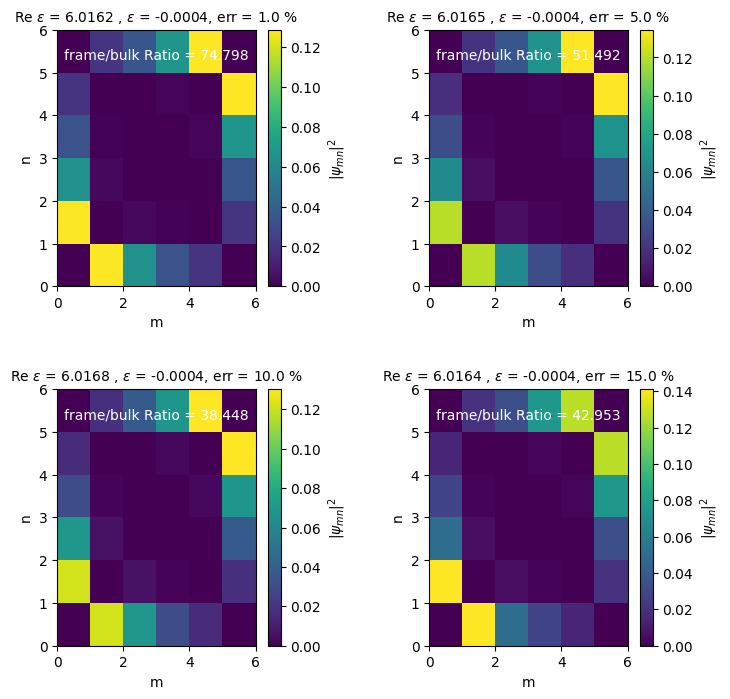

In [ ]:
######################################################################################################################
# Plot the amplitudes/wavefunctions of the eigensolution we are interested in for different err values
######################################################################################################################
err_values = [0.01, 0.05, 0.1, 0.15]  # List of err values to iterate over

fig, axs = plt.subplots(2, 2, figsize=(8, 8))  # Create subplots for each err value

for i, err in enumerate(err_values):
    omega_val, gamma_val = err_val_gamma(err, omega0, gamma0, N, d)
    print(gamma_val)
    H0r = construct_full_H(6, omega_val, d, gamma_val,phi0, -0.99)

    e_val_2exc, e_vec_2exc = get_2excitations_states(N, H0r)  # find two excitations eigenvectors and eigenvalues with cavity

    # Here we already know that the eigenstate we are interested in is with index = 9 #???
    Psis_val, _ = get_amplitudes(e_vec_2exc[9], N)  # find amplitudes and iprs of desired eigenstate (with cavity)

    ########################################
    #we write the ratio of frame vs. bulk
    ########################################
    # I chose to show the ratio of the mean frame value and the mean bulk value
    psis_bulk_sum = sum([Psis_val[n][m] for n in range(1,N-1) for m in range(1,N-1)])
    psis_bulk_mean = psis_bulk_sum / ((N-2)**2)

    psis_frame_sum = sum(Psis_val[0]) + sum(Psis_val[N-1]) + sum(Psis_val[i][0] for i in range(N)) + sum(Psis_val[i][N-1] for i in range(N))
    psis_frame_mean = psis_frame_sum / (2*(N+N-2))
    Psis_frame_bulk_ratio = psis_frame_mean / psis_bulk_mean

    ########################################


    ax = axs[i // 2, i % 2]

    pcmesh = ax.pcolormesh(Psis_val)
    ax.set_xlabel('m')
    ax.set_ylabel('n')
    ax.set_title(r'Re $\epsilon$ = %.4f , $\epsilon$ = %.4f, err = %.1f %%' % (np.real(e_val_2exc[9]), np.imag(e_val_2exc[9]), err*100), fontsize=10)

    # Add Psis_bulk_frame_ratio value as text on the graph
    ax.text(0.5, 0.9, f'frame/bulk Ratio = %.3f' % Psis_frame_bulk_ratio, color='white', transform=ax.transAxes, ha='center', va='center')


    cbar = fig.colorbar(pcmesh, ax=ax)
    cbar.set_label(r'$|\psi_{mn}|^{2}$')

plt.subplots_adjust(wspace=0.5, hspace=0.4)  # Adjust the spacing between subplots

plt.show()

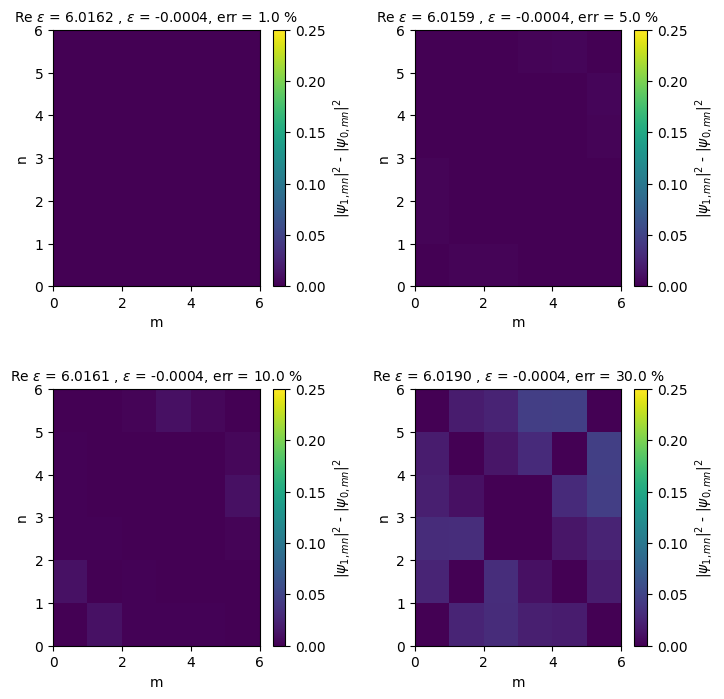

In [ ]:
######################################################################################################################
# Plot the normalized distance between the psi(m,n) values of err= 0 and diff error values
######################################################################################################################
err_values = [0.01, 0.05, 0.1, 0.30]  # List of err values to iterate over

# Calculate Psis_val for err0
omega_val0, gamma_val0 = err_val_omega(0, omega0, gamma0, N, d)
H0r0= construct_full_H(6, omega_val0, d, gamma_val0,phi0, -0.99)
e_val_2exc0, e_vec_2exc0 = get_2excitations_states(N, H0r0)

Psis_val0, _ = get_amplitudes(e_vec_2exc0[9], N)


fig, axs = plt.subplots(2,2,figsize=(8,8)) # Create subplots for each err value

# Loop over error values
for i, err in enumerate(err_values):
    omega_val, gamma_val = err_val_gamma(err, omega0, gamma0, N, d, )
    H0r= construct_full_H(6,omega_val,d,gamma_val,phi0, -0.99)

    e_val_2exc,e_vec_2exc = get_2excitations_states(N,H0r) # find two excitations eigenvectors and eigenvalues with cavity

    # Here we already know that the eigenstate we are interested in is with index = 9 #???
    Psis_val, _ = get_amplitudes(e_vec_2exc[9], N) # find amplitudes and iprs of desired eigenstate (with cavity)

    # List to store Psis_val differences
    Psis_val_dist = []

    # Ensure Psis_val and Psis_val0 are numpy arrays
    Psis_val = np.array(Psis_val)
    Psis_val0 = np.array(Psis_val0)

    # Calculate the normalized distance for each pair of corresponding elements
    Psis_val_dist = np.abs(Psis_val - Psis_val0)


    ax = axs[i // 2, i % 2]

    pcmesh = ax.pcolormesh(Psis_val_dist,vmin=0, vmax=0.25)
    ax.set_xlabel('m')
    ax.set_ylabel('n')
    ax.set_title(r'Re $\epsilon$ = %.4f , $\epsilon$ = %.4f, err = %.1f %%' % (np.real(e_val_2exc[9]), np.imag(e_val_2exc[9]), err*100), fontsize=10)


    cbar = fig.colorbar(pcmesh,ax=ax)
    cbar.set_label(r'$|\psi_{1,mn}|^{2}$ - $|\psi_{0,mn}|^{2}$')

#fig.colorbar(im, ax=ax0)
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust the spacing between subplots

plt.show()

##why is the diag==1 ? is it quantum physics or a misscuaclculation?


w 0
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list


C:\Users\yulil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


w 1
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w 2
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list
w1_list


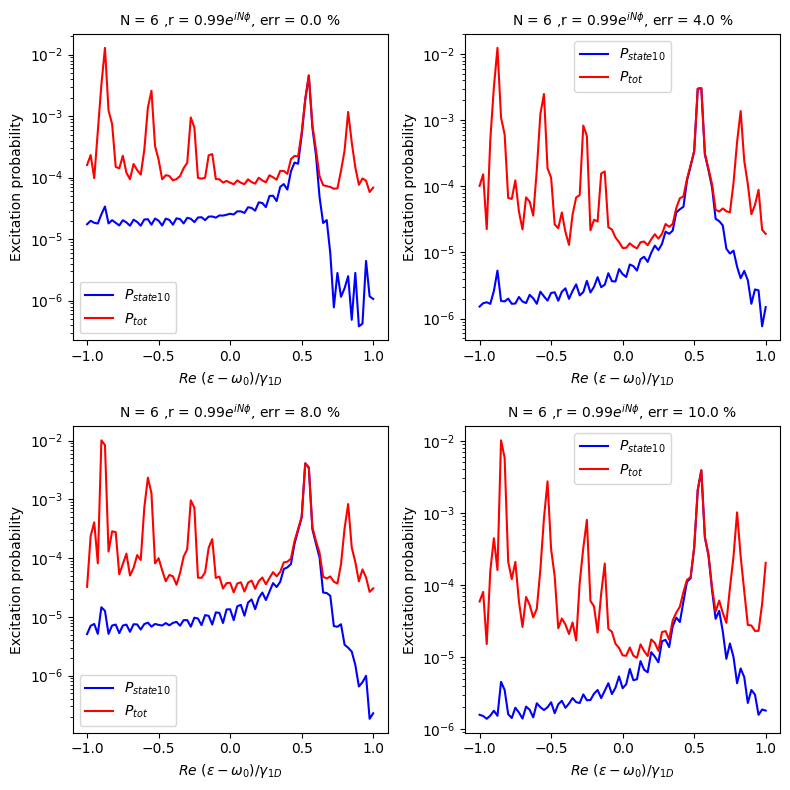

[0.55, 0.55, 0.5250000000000001, 0.55]


In [ ]:
#########################################################################################################################################################
### Add driving: excitation of the desired two-excitation eigenstate.
### Plot probability of exciting desired two-excitation eigenstate as function of driving frequency for the case of driving
#via first transmon and via waveguide
#########################################################################################################################################################
err_values = [0.00, 0.04, 0.08,0.1]  # List of err values to iterate over

fig, axs = plt.subplots(2,2,figsize=(8,8)) # Create subplots for each err value

drive_w_values = []

# Loop over error values
for i, err in enumerate(err_values):
    print("w",i)
    # Calculate relevant values to err value
    omega_val, gamma_val = err_val_gamma(err, omega0, gamma0, N, d)
    gamma = gamma_val[0]#################################################??>
    ###############################################################
    #we drive the desired two-excitation eigenstate via waveguide
    #to diff error values of omega and phi
    ###############################################################
    # define parameters
    w1_list = np.linspace(-1,1,81) # epsilon/gamma_{1D} in the range of [-1,1]
    #gamma = 0.005*omega
    Delta = 20*(gamma/(2*np.pi)) # large detunning (Delta/2)/gamma = 10
    E0 = 0.2*gamma/(2*np.pi) # Pulse amplitude ##CH
    q_dim = 2 # consider only two transmon levels
    psi_init = tensor([basis(q_dim,0)]*N) # initial state of 6 transmons in ground state
    tlist = np.linspace(0,18000,800)/(2*np.pi)

    # the enviorment influance (usually empty opreators)
    col_ops = [] # collapse operator represent here decay to enviorment, not to the waveguide
    exp_ops = [] # don't include expectation value operators, calculate based on density matrix

    P1state = [] # to hold probabilities of the state we are interested in
    Ptots = [] # to hold total probability of two-excitation states

    # N-dim sigma+ and sigma- operators for excitation through the waveguide - Em = e^(i*phi*m) + r*e^(i*phi*N)*e^(-i*k*zm)
    Hwgexc_plus = construct_wg_driving_operator_plus(N,phi0,-0.99,q_dim)
    Hwgexc_minus = construct_wg_driving_operator_minus(N,phi0,-0.99,q_dim)

    H0 = construct_full_H(6,omega_val,d,gamma_val,phi0, -0.99)
    evals_2exc,evecs_2exc = get_2excitations_states(N,H0,q_dim) # find two-excitation eigenstates

    for wi in w1_list:
        print("w1_list")
        args_exc = {'E':E0,'eps0':omega0/(2*np.pi)+wi*(gamma0/(2*np.pi)),'Delta0':Delta}# arguments for the exponent function describing qubit excitation
        # excitation through the waveguide
        Htot = [H0,[Hwgexc_plus,exc_f_plus],[Hwgexc_minus,exc_f_minus]]
        result = mesolve(Htot,psi_init,tlist,col_ops,exp_ops,args=args_exc)
        rho = result.states[-1]*result.states[-1].dag() # define density matrix rho
        P1state.append((rho*construct_2excitation_creation_operator(evecs_2exc[9],N,q_dim)*construct_2excitation_creation_operator(evecs_2exc[9],N,q_dim).dag()).tr())

        Ptot = 0
        for v in evecs_2exc:
            Ptot += (rho*construct_2excitation_creation_operator(v,N,q_dim)*construct_2excitation_creation_operator(v,N,q_dim).dag()).tr()
        Ptots.append(Ptot)

    ####find w1 of each graph
    # Find the index of the maximum value
    max_index = np.argmax(P1state)

    # Get the corresponding maximum value
    drive_w = w1_list[max_index]
    drive_w_values.append(drive_w)


    ### Prepare for plotting
    ax = axs[i // 2, i % 2]  # Determine the current subplot
    ax.plot(w1_list, P1state,'b', label=r"$P_{state 10}$")
    ax.plot(w1_list, Ptots,'r', label=r"$P_{tot}$")

    ax.set_yscale('log')
    ax.set_xlabel(r'$Re ~\left(\epsilon - \omega_{0} \right) / \gamma_{1D}$')
    ax.set_ylabel('Excitation probability')
    ax.set_title(r'N = %d ,r = 0.99$e^{iN\phi}$, err = %.1f %%' % (N,err*100), fontsize=10)


    ax.legend()

plt.tight_layout()  # Adjust the layout to prevent overlaps
plt.show()
print(drive_w_values)

##noticed that as the error gets bigger - the maximum point tends to vary more


[0.55, 0.55, 0.5250000000000001, 0.55]


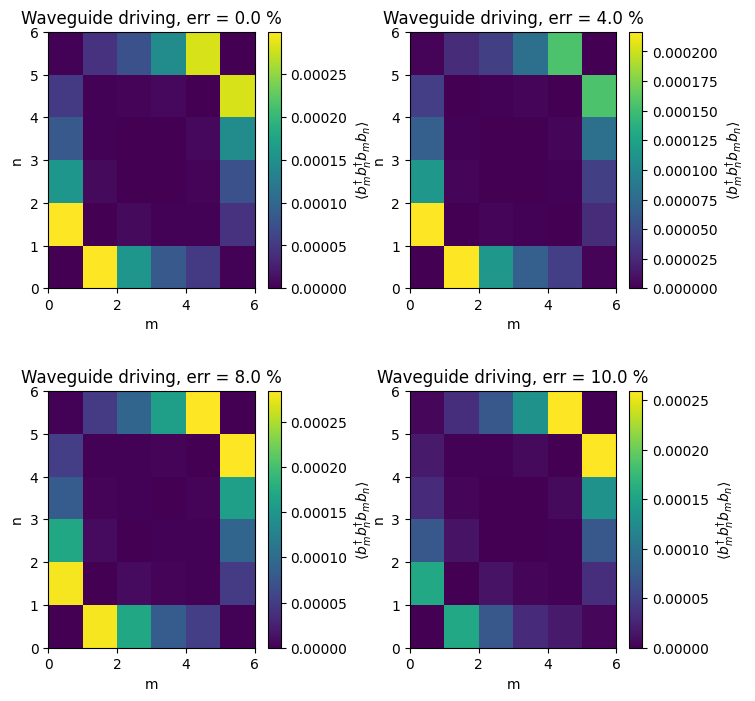

In [ ]:
# parameters
N = 6 # number of transmons in the model
c_light = 3E-1 #  0.3 m/ns
d = 5E-3 # 0.005 m

omega0 = 6 * (2*np.pi) # omega0 ~ 6 GHz
gamma0 = 0.03 * (2*np.pi) # gamma_1D ~ 30 MHz
phi0 = np.round(omega0*d/c_light / (2*np.pi),5) # phi = 0.1


alpha = -0.25 * (2*np.pi) # 200 MHz
q_dim = 2 # Use only first two transmon levels
r_cavity = -0.99 # cavity/mirror reflection coefficient

print(drive_w_values)

## Set the pulse frequency epsilon to the peak corresponding to the edge state, measure pair correlations between transmons (expect to reproduce the map of the wavefunctions)
#define parameters
#wi = 0.48 # epsilon/gamma_{1D} in the range of [-1,1]
Delta = 20*(gamma0/(2*np.pi)) # large detunning (Delta/2)/gamma = 10
E0 = 0.2*gamma0/(2*np.pi) # Pulse amplitude
q_dim = 2 # consider only two transmon levels
psi_init = tensor([basis(q_dim,0)]*N) # initial state of 6 transmons in ground state
tlist = np.linspace(0,18000,800)/(2*np.pi)
gamma_relaxation = 0.0001*omega0
gamma_dephasing = 0.005*omega0




#exp_ops.append(construct_2excitation_creation_operator(evecs_2exc[9],N,q_dim)*construct_2excitation_creation_operator(evecs_2exc[9],N,q_dim).dag())

fig, axs = plt.subplots(2,2,figsize=(8,8)) # Create subplots for each err value

# Loop over error values
for i, err in enumerate(err_values):
    num_maps_wg = []

    wi = drive_w_values[i]

    col_ops = [] # collapse operator represent here decay to enviorment, not to the waveguide
    exp_ops = [] # don't include expectation value operators, calculate based on density matrix

    # N-dim sigma+ and sigma- operators for excitation through the waveguide - Em = e^(i*phi*m) + r*e^(i*phi*N)*e^(-i*k*zm)
    Hwgexc_plus = construct_wg_driving_operator_plus(N,phi0,-0.99,q_dim)
    Hwgexc_minus = construct_wg_driving_operator_minus(N,phi0,-0.99,q_dim)

    omega_val, gamma_val = err_val_gamma(err, omega0, gamma0, N, d)
    args_exc_wg = {'E':E0,'eps0':omega0/(2*np.pi)+wi*(gamma0/(2*np.pi)),'Delta0':Delta}# arguments for the exponent function describing qubit excitation

    H0 = construct_full_H(6,omega_val,d,gamma_val,phi0,-0.99,q_dim)
    evals_2exc,evecs_2exc = get_2excitations_states(N,H0,q_dim) # find two-excitation eigenstates
    #H0 = Qobj(np.real(H0),dims=H0.dims) # now convert to the real part for the driven H

    options = qutip.solver.Options()
    options.store_final_state = True


    # excitation through the waveguide
    Htot_wg = [H0,[Hwgexc_plus,exc_f_plus],[Hwgexc_minus,exc_f_minus]]
    result_wg = mesolve(Htot_wg,psi_init,tlist,col_ops,exp_ops,args=args_exc_wg)
    rho_wg = result_wg.states[-1]*result_wg.states[-1].dag()# define density matrix rho

    # initialize a N X N array to store the amplitudes
    num_map_wg = np.zeros((N,N))

    for m in range(N):
        for n in range(N):
            cor_map = [qeye(q_dim)]*N
            cor_map[m] = cor_map[m]*create(q_dim)
            cor_map[n] = cor_map[n]*create(q_dim)
            cor_map[m] = cor_map[m]*destroy(q_dim)
            cor_map[n] = cor_map[n]*destroy(q_dim)
            num_map_wg[m,n] = (rho_wg*tensor(cor_map)*tensor(cor_map).dag()).tr()

    ax = axs[i // 2, i % 2]  # Determine the current subplot

    pcmesh = ax.pcolormesh(num_map_wg)

    ax.set_xlabel('m')
    ax.set_ylabel('n')

    ax.set_title('Waveguide driving, err = %.1f %%' % (err*100))

    cbar = fig.colorbar(pcmesh,ax=ax)
    cbar.set_label(r'$\langle b_m^{\dagger} b_n^{\dagger} b_m b_n \rangle$')

#fig.colorbar(im, ax=ax0)
plt.subplots_adjust(wspace=0.4,hspace=0.4)

plt.show()


